
=== Test de Hipótesis para Actividad por Día de la Semana ===

🔹 **Visitas por día de la semana**
Monday: t-stat = nan, p-value (one-tailed) = nan
   -> No hay diferencia significativa (no rechazamos H0).
Tuesday: t-stat = nan, p-value (one-tailed) = nan
   -> No hay diferencia significativa (no rechazamos H0).
Wednesday: t-stat = nan, p-value (one-tailed) = nan
   -> No hay diferencia significativa (no rechazamos H0).
Thursday: t-stat = nan, p-value (one-tailed) = nan
   -> No hay diferencia significativa (no rechazamos H0).
Friday: t-stat = nan, p-value (one-tailed) = nan
   -> No hay diferencia significativa (no rechazamos H0).
Saturday: t-stat = nan, p-value (one-tailed) = nan
   -> No hay diferencia significativa (no rechazamos H0).
Sunday: t-stat = nan, p-value (one-tailed) = nan
   -> No hay diferencia significativa (no rechazamos H0).




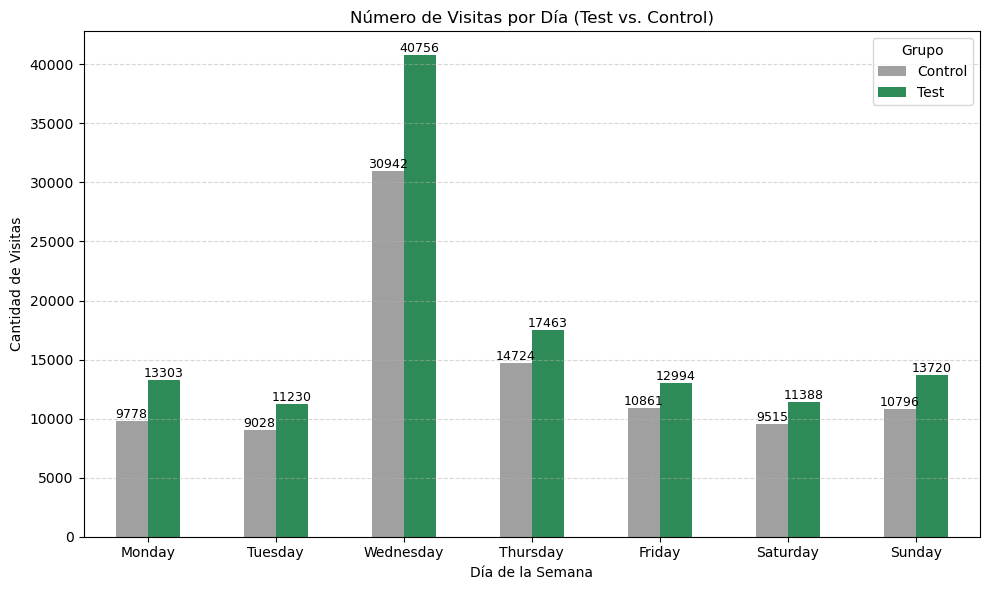

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --------------------------------------------------
# PASO 1: Cargar el DataFrame y convertir 'date_time' a datetime
# --------------------------------------------------
df = pd.read_csv("../../data/processed/navegacion_clientes_experimento_limpio.csv")
df["date_time"] = pd.to_datetime(df["date_time"])

# --------------------------------------------------
# PASO 2: Extraer el día de la semana
# --------------------------------------------------
df["day_of_week"] = df["date_time"].dt.dayofweek  # 0=Lunes, 6=Domingo
day_name_map = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 
                4: "Friday", 5: "Saturday", 6: "Sunday"}
df["day_name"] = df["day_of_week"].map(day_name_map)

# Filtrar solo columnas necesarias
df_activity = df[["variation", "day_name", "visit_id", "calls_6_mnth", "logons_6_mnth"]].copy()

# --------------------------------------------------
# PASO 3: Convertir columnas a valores numéricos para evitar errores en el T-Test
# --------------------------------------------------
df_activity["calls_6_mnth"] = pd.to_numeric(df_activity["calls_6_mnth"], errors="coerce")
df_activity["logons_6_mnth"] = pd.to_numeric(df_activity["logons_6_mnth"], errors="coerce")

# --------------------------------------------------
# PASO 4: Calcular la actividad media por día y grupo
# --------------------------------------------------
df_activity_means = (
    df_activity.groupby(["day_name", "variation"])
    .agg({"visit_id": "count", "calls_6_mnth": "mean", "logons_6_mnth": "mean"})
    .reset_index()
)

# Convertir a formato pivot para graficar
df_visits = df_activity_means.pivot(index="day_name", columns="variation", values="visit_id")
df_calls = df_activity_means.pivot(index="day_name", columns="variation", values="calls_6_mnth")
df_logins = df_activity_means.pivot(index="day_name", columns="variation", values="logons_6_mnth")

# Ordenar días correctamente
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_visits = df_visits.reindex(day_order)
df_calls = df_calls.reindex(day_order)
df_logins = df_logins.reindex(day_order)

# --------------------------------------------------
# PASO 5: Test de Hipótesis (T-Test) para cada métrica
# --------------------------------------------------
alpha = 0.05
metric_map = {"Visitas": "visit_id"}

print("\n=== Test de Hipótesis para Actividad por Día de la Semana ===\n")

for metric_name, column_name in metric_map.items():
    print(f"🔹 **{metric_name} por día de la semana**")
    for day in day_order:
        test_values = df_activity[(df_activity["day_name"] == day) & (df_activity["variation"] == "Test")][column_name]
        control_values = df_activity[(df_activity["day_name"] == day) & (df_activity["variation"] == "Control")][column_name]

        test_values = test_values.dropna()
        control_values = control_values.dropna()

        if len(test_values) < 2 or len(control_values) < 2:
            print(f"{day}: Datos insuficientes en Test o Control.")
            continue

        # Asegurar que los valores sean numéricos
        test_values = pd.to_numeric(test_values, errors='coerce').dropna()
        control_values = pd.to_numeric(control_values, errors='coerce').dropna()

        t_stat, p_two_tailed = stats.ttest_ind(test_values, control_values, equal_var=False)
        p_one_tailed = p_two_tailed / 2 if t_stat < 0 else 1 - p_two_tailed / 2

        print(f"{day}: t-stat = {t_stat:.4f}, p-value (one-tailed) = {p_one_tailed:.6f}")
        if p_one_tailed < alpha:
            print("   -> Diferencia significativa (rechazamos H0).")
        else:
            print("   -> No hay diferencia significativa (no rechazamos H0).")
    print("\n")

# --------------------------------------------------
# PASO 6: Graficar la actividad por día de la semana
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Definir colores corregidos
color_map = {"Control": "#A0A0A0", "Test": "#2E8B57"}

# Gráfico: Número de visitas por día
df_visits.plot(kind="bar", ax=ax, color=[color_map.get(col, "gray") for col in df_visits.columns])
ax.set_title("Número de Visitas por Día (Test vs. Control)")
ax.set_ylabel("Cantidad de Visitas")
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Ajustes finales
ax.set_xlabel("Día de la Semana")
ax.set_xticklabels(day_order, rotation=0)
ax.legend(title="Grupo")
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f"{height:.0f}" if height >= 1 else f"{height:.2f}",
                    (p.get_x() + p.get_width()/2, height),
                    ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("../../img/4_activity_by_day.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# Pass graph dataframe to csv
df_visits.to_csv("../../data/processed/4_ActivityDay.csv")